<a href="https://colab.research.google.com/github/ByungjunKim/ModernKoreanSubword/blob/main/ModernKoreanSubword_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 근대 한국어 서브워드 형태소 분석기 학습

### 서브워드 학습 준비

In [1]:
import pandas as pd

# kiwi 로드
from kiwipiepy import Kiwi
kiwi = Kiwi()
from kiwipiepy.sw_tokenizer import SwTokenizer
from kiwipiepy.sw_tokenizer import SwTokenizerConfig
import gc
import hanja
import pickle
import bz2

##### 한국근대잡지 

In [3]:
# 근대 잡지
with bz2.BZ2File('./한국근현대잡지자료.pkl.bz2', 'rb') as f:
   mag = pickle.load(f)
mag

,level3id,mainTitle,subjectClass,pTitle,paragraph,level2id,level1id,mainTitle_권호,publisher,dateIssued,mainTitle_잡지
0,ma_001_0010_0010,大韓自强會月報序［三編］,논설,大韓自强會月報序［三編］,\n大韓自强會月報序［三編］\n,ma_001_0010,ma_001,대한자강회월보 제1호,대한자강회,1906-07-31,대한자강회월보
1,ma_001_0010_0010,大韓自强會月報序［三編］,논설,大韓自强會月報序［三編］,＜1-4＞,ma_001_0010,ma_001,대한자강회월보 제1호,대한자강회,1906-07-31,대한자강회월보
2,ma_001_0010_0010,大韓自强會月報序［三編］,논설,大韓自强會月報序［三編］,\n南嵩山人曰誰道日本之少文章哉此篇文字明確正大其組織極精緻極宏博至其論國家正義處尤切時病令...,ma_001_0010,ma_001,대한자강회월보 제1호,대한자강회,1906-07-31,대한자강회월보
3,ma_001_0010_0010,大韓自强會月報序［三編］,논설,大韓自强會月報序［三編］,\n金陵\n大垣丈夫\n,ma_001_0010,ma_001,대한자강회월보 제1호,대한자강회,1906-07-31,대한자강회월보
4,ma_001_0010_0010,大韓自强會月報序［三編］,논설,大韓自强會月報序［三編］,蓋韓國二千萬人中豈無達者也哉余嘗結交其士君子知有老練精達之人傑見有少壯有爲之人士而今則如此何...,ma_001_0010,ma_001,대한자강회월보 제1호,대한자강회,1906-07-31,대한자강회월보
...,...,...,...,...,...,...,...,...,...,...,...
588569,ma_095_0260_0140,버드나무 그늘의 少女,<NA>,버드나무 그늘의 少女,\n버드나무 그늘의 少女\n尹影\n,ma_095_0260,ma_095,호남평론 제3권 제8호,<NA>,1937-08-15,호남평론
588570,ma_095_0260_0150,詩: 바다가에서,<NA>,詩: 바다가에서,\n詩: 바다가에서\n一石\n,ma_095_0260,ma_095,호남평론 제3권 제8호,<NA>,1937-08-15,호남평론
588571,ma_095_0260_0160,戱曲: 水害後,<NA>,戱曲: 水害後,\n戱曲: 水害後\n朴東和\n,ma_095_0260,ma_095,호남평론 제3권 제8호,<NA>,1937-08-15,호남평론
588572,ma_095_0260_0170,詩: H孃의 半生記,<NA>,詩: H孃의 半生記,\n詩: H孃의 半生記\n溝隱\n,ma_095_0260,ma_095,호남평론 제3권 제8호,<NA>,1937-08-15,호남평론


In [4]:
# 연도 추출
mag['year'] = mag['dateIssued'].str.slice(0,4).astype(int)

In [5]:
# 1940까지 활용
mag = mag[mag['year']<=1940].reset_index(drop=True)

<Axes: xlabel='year'>

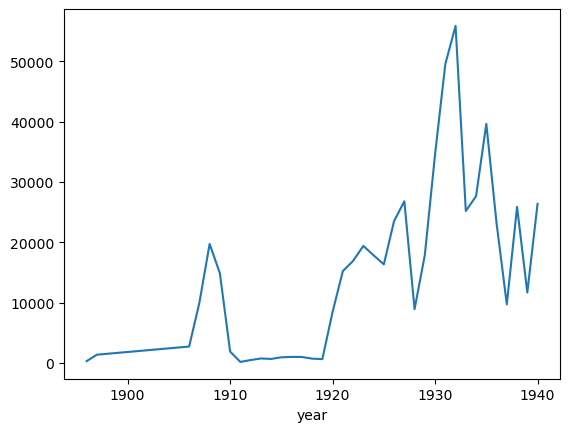

In [6]:
mag['year'].value_counts().sort_index().plot()

In [7]:
# 10년 단위로 문단수 통계 내기
# Create a new column for 10-year intervals
mag['decade'] = (mag['year'] // 10) * 10

# Calculate the frequency of each decade
decade_counts = mag['decade'].value_counts().sort_index()

# Format the index to display as "1880년대", "1890년대", etc.
decade_counts.index = [f"{decade}년대" for decade in decade_counts.index]

# Display the result
print(decade_counts)

1890년대      1664
1900년대     47261
1910년대      8198
1920년대    171235
1930년대    302766
1940년대     26357
Name: count, dtype: int64


In [7]:
mag_paragraph = mag['paragraph'].tolist()

In [8]:
del mag

##### 조선일보

In [8]:
# 조선일보
chosun = pd.read_parquet('/mnt/hdd/bjkim/ModernConcept/chosun_preprocessed.parquet',columns=['year','type','body_archaic'])

In [9]:
chosun = chosun.dropna()
chosun

,year,type,body_archaic
0,1920,smallad,祝 …朝；蘚 n 報創 刊\n趙… . … . 命· 九\n
4,1920,article,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...
5,1920,article,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...
6,1920,etc,祝詞와祝電\n
7,1920,article,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸..."
...,...,...,...
4679014,1999,article,폐품 할머니\n40년간 고물 수집\n외대 1억 기증후 타계\n 지난 7월 장경자(張...
4679015,1999,article,고시준비생 장학금\n외대에 3억원 전달\n商街주인 할머니\n 지난 14일힐튼호텔 컨...
4679016,1999,article,“1900년에 출두하시오”\n수원지법 컴퓨터‘Y2K’\n피고인에 엉뚱한 소환장\n ...
4679017,1999,photo,◇故장경자씨\n


In [10]:
chosun = chosun[chosun['year']<=1940].reset_index(drop=True)
chosun

,year,type,body_archaic
0,1920,smallad,祝 …朝；蘚 n 報創 刊\n趙… . … . 命· 九\n
1,1920,article,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...
2,1920,article,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...
3,1920,etc,祝詞와祝電\n
4,1920,article,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸..."
...,...,...,...
930051,1940,article,"各界人物招致\n首相,意見交換豫定\n【東京電話同盟】新體制確立에關하여 그根本原理組織方法..."
930052,1940,article,臨時家族手當\n十月부터實施决定\n【東京電話同盟】政府는 九日閣議에서 下級官吏에 臨時家...
930053,1940,article,"外相,首相과會談\n【東京電話同盟】松岡外相은 九日定例閣議散會後 首相官邸에남어 近衞首相..."
930054,1940,article,人事·集會\n▲朱□宜氏(前普成中學校長)退任人事次十日來社\n▲鈴木文次郞氏(全朝鮮洋服商...


In [11]:
# 중복제거
chosun = chosun.drop_duplicates('body_archaic').reset_index(drop=True)
chosun

,year,type,body_archaic
0,1920,smallad,祝 …朝；蘚 n 報創 刊\n趙… . … . 命· 九\n
1,1920,article,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...
2,1920,article,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...
3,1920,etc,祝詞와祝電\n
4,1920,article,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸..."
...,...,...,...
900622,1940,article,"各界人物招致\n首相,意見交換豫定\n【東京電話同盟】新體制確立에關하여 그根本原理組織方法..."
900623,1940,article,臨時家族手當\n十月부터實施决定\n【東京電話同盟】政府는 九日閣議에서 下級官吏에 臨時家...
900624,1940,article,"外相,首相과會談\n【東京電話同盟】松岡外相은 九日定例閣議散會後 首相官邸에남어 近衞首相..."
900625,1940,article,人事·集會\n▲朱□宜氏(前普成中學校長)退任人事次十日來社\n▲鈴木文次郞氏(全朝鮮洋服商...


In [12]:
# br 태그 삭제
chosun['body_archaic'] = chosun['body_archaic'].str.replace('</br>','')

In [13]:
# 【三十日東京特電】 처럼 특파원 삭제
chosun['body_archaic'] = chosun['body_archaic'].str.replace('\【.+\】','',regex=True)

In [14]:
chosun = chosun.dropna(subset=['body_archaic']).reset_index(drop=True)
chosun = chosun.drop_duplicates('body_archaic').reset_index(drop=True)
chosun

,year,type,body_archaic
0,1920,smallad,祝 …朝；蘚 n 報創 刊\n趙… . … . 命· 九\n
1,1920,article,朝鮮日報\n創刊을祝함\n候爵 大隈重信\n朝鮮合邦以來歲를閱한지玆에十年이되鮮人의自營하난...
2,1920,article,朝鮮現下의\n工業狀態\n를鑑하야振興策\n을一二를言함\n朝鮮의工業으로言하면從來此를賤視...
3,1920,etc,祝詞와祝電\n
4,1920,article,"大正八年朝鮮貿易槪况(一)\n(朝鮮總督府財務局調査)\n一,總况\n大正八年朝鮮貿易額은輸..."
...,...,...,...
900471,1940,article,"各界人物招致\n首相,意見交換豫定\n新體制確立에關하여 그根本原理組織方法等에關하여 愼重..."
900472,1940,article,臨時家族手當\n十月부터實施决定\n政府는 九日閣議에서 下級官吏에 臨時家族手當支給을 决...
900473,1940,article,"外相,首相과會談\n松岡外相은 九日定例閣議散會後 首相官邸에남어 近衞首相과 會見하고 當..."
900474,1940,article,人事·集會\n▲朱□宜氏(前普成中學校長)退任人事次十日來社\n▲鈴木文次郞氏(全朝鮮洋服商...


In [15]:
# 10년 단위로 문단수 통계 내기
# Create a new column for 10-year intervals
chosun['decade'] = (chosun['year'] // 10) * 10

# Calculate the frequency of each decade
decade_counts = chosun['decade'].value_counts().sort_index()

# Format the index to display as "1880년대", "1890년대", etc.
decade_counts.index = [f"{decade}년대" for decade in decade_counts.index]

# Display the result
print(decade_counts)

1920년대    340320
1930년대    525253
1940년대     34903
Name: count, dtype: int64


In [31]:
chosun_paragraph = chosun['body_archaic'].tolist()

In [32]:
del chosun

##### 동아일보 

In [16]:
# 동아일보
donga = pd.read_parquet('/mnt/hdd/bjkim/ModernConcept/donga_preprocessed.parquet',columns=['year','body_ori'])
donga

,year,body_ori
0,1920,主旨를宣明하노라\n蒼天에太陽이빗나고大地에淸風이불도다山靜水流하며草木昌茂하며百花爛發하며...
1,1920,九十度난太甚\n혹독한형벌인우에\n따리는데도불공도\n스코필트씨밀\n관텽에서 허가하는 ...
2,1920,肉體보다도精神\n몸을앗김보다\n명예를위하라\n방하춍독무의원장의말사월초하ㄹ날로무터 태...
3,1920,四十七人의公判\n셰길이넘는긔록을조사하기에\n판검사아홉명이매여달녀잇다\n느저도금년안에...
4,1920,姜宇奎公判은\n금월오일개정\n남대문역두에서 재등춍독에게폭탄을던지여 한세상을 떠들니든...
...,...,...
3125897,1999,키노코너\n독립영화협의회가 주최하는 제26회 독립영화 워크숍이 2000년 1월3일부...
3125898,1999,한국영화 대약진“올해만 같아라”\n점유율 40% 육박…작품성은 미흡\n외화 상대적 ...
3125899,1999,1999년 영화계 결산\n99 한국영화 흥행 베스트10\n99 외국영화 흥행 베스트10
3125900,1999,"Y2K D-1\n업무 본격시작 1월3,4일 더 위험\n‘Y2K D—1’\n컴퓨터의 ..."


In [17]:
donga = donga[donga['year']<=1940].dropna().reset_index(drop=True)
donga

,year,body_ori
0,1920,主旨를宣明하노라\n蒼天에太陽이빗나고大地에淸風이불도다山靜水流하며草木昌茂하며百花爛發하며...
1,1920,九十度난太甚\n혹독한형벌인우에\n따리는데도불공도\n스코필트씨밀\n관텽에서 허가하는 ...
2,1920,肉體보다도精神\n몸을앗김보다\n명예를위하라\n방하춍독무의원장의말사월초하ㄹ날로무터 태...
3,1920,四十七人의公判\n셰길이넘는긔록을조사하기에\n판검사아홉명이매여달녀잇다\n느저도금년안에...
4,1920,姜宇奎公判은\n금월오일개정\n남대문역두에서 재등춍독에게폭탄을던지여 한세상을 떠들니든...
...,...,...
1001312,1940,手術界의驚異\n醫學朝鮮에凱旋歌\n없는男子生殖 를붙이기에 드디어成功\n世專李鶴松博士의...
1001313,1940,三年後에오는大京城\n二百萬人口를收容\n十八年度 지七個地區에新市街地를形成\n京城府에서...
1001314,1940,張皷峯事件二 年記念\n今日、嚴肅히擧行\n正午를期해一齊默禱\n황군전사(皇軍戰史)에 최...
1001315,1940,辯護士試驗延長\n受驗生代表들이再次當局에陳情\n누보한바와같이 조선에잇어서의 변호사시험...


In [18]:
donga = donga.drop_duplicates('body_ori').reset_index(drop=True)
donga

,year,body_ori
0,1920,主旨를宣明하노라\n蒼天에太陽이빗나고大地에淸風이불도다山靜水流하며草木昌茂하며百花爛發하며...
1,1920,九十度난太甚\n혹독한형벌인우에\n따리는데도불공도\n스코필트씨밀\n관텽에서 허가하는 ...
2,1920,肉體보다도精神\n몸을앗김보다\n명예를위하라\n방하춍독무의원장의말사월초하ㄹ날로무터 태...
3,1920,四十七人의公判\n셰길이넘는긔록을조사하기에\n판검사아홉명이매여달녀잇다\n느저도금년안에...
4,1920,姜宇奎公判은\n금월오일개정\n남대문역두에서 재등춍독에게폭탄을던지여 한세상을 떠들니든...
...,...,...
922467,1940,手術界의驚異\n醫學朝鮮에凱旋歌\n없는男子生殖 를붙이기에 드디어成功\n世專李鶴松博士의...
922468,1940,三年後에오는大京城\n二百萬人口를收容\n十八年度 지七個地區에新市街地를形成\n京城府에서...
922469,1940,張皷峯事件二 年記念\n今日、嚴肅히擧行\n正午를期해一齊默禱\n황군전사(皇軍戰史)에 최...
922470,1940,辯護士試驗延長\n受驗生代表들이再次當局에陳情\n누보한바와같이 조선에잇어서의 변호사시험...


In [20]:
# 10년 단위로 문단수 통계 내기
# Create a new column for 10-year intervals
donga['decade'] = (donga['year'] // 10) * 10

# Calculate the frequency of each decade
decade_counts = donga['decade'].value_counts().sort_index()

# Format the index to display as "1880년대", "1890년대", etc.
decade_counts.index = [f"{decade}년대" for decade in decade_counts.index]

# Display the result
print(decade_counts)

1920년대    372290
1930년대    511036
1940년대     39146
Name: count, dtype: int64


In [19]:
donga_paragraph = donga['body_ori'].tolist()

In [37]:
del donga

In [38]:
paragraph_list = mag_paragraph + chosun_paragraph + donga_paragraph
len(paragraph_list)

2380429

In [39]:
del mag_paragraph, chosun_paragraph, donga_paragraph

In [40]:
gc.collect()

184

In [41]:
len(paragraph_list)

2380429

In [ ]:
# 중복삭제
len(list(dict.fromkeys(paragraph_list)))

2287985

In [45]:
paragraph_list = list(dict.fromkeys(paragraph_list))

In [ ]:
# save
# with open('./paragraph_list.pickle', 'wb') as f:
#     pickle.dump(paragraph_list, f, pickle.HIGHEST_PROTOCOL)
with bz2.BZ2File('./paragraph_list.pkl.bz2', 'wb') as f:
    pickle.dump(paragraph_list, f)

### 서브워드 학습

In [ ]:
# load
# with open('./paragraph_list.pickle', 'rb') as f:
#     paragraph_list = pickle.load(f)
with bz2.BZ2File('paragraph_list.pkl.bz2', 'rb') as f:
   paragraph_list = pickle.load(f)

In [ ]:
# https://bab2min.github.io/kiwipiepy/v0.15.2/kr/sw_tokenizer.html#kiwipiepy.sw_tokenizer.SwTokenizerConfig
config = SwTokenizerConfig(split_chinese=False) # split_chinese 제외하고 모두 기본 옵션 사용

In [ ]:
# 학습
# save_path = 토크나이저.json 파일 저장 위치
# texts = 학습할 데이터(리스트)
# vocab_size = 단어수
# config = 학습 옵션
tokenizer = SwTokenizer.train(save_path='./241112_vo32000_tokenizer.json', texts=paragraph_list, vocab_size=32000, config=config)

Reducing #1:   0%|          | 0/1000 [00:00<?, ?it/s, vocab_size=8557579, loss=8.72]

Iteration: 0 VocabSize: 8557579 Loss: 8.7211


Reducing #1:   0%|          | 1/1000 [00:30<8:29:12, 30.58s/it, vocab_size=6155199, loss=8.58]

Iteration: 1 VocabSize: 6155199 Loss: 8.5833


Reducing #1:   0%|          | 2/1000 [01:01<8:34:34, 30.94s/it, vocab_size=5490883, loss=8.57]

Iteration: 2 VocabSize: 5490883 Loss: 8.5747


Reducing #1:   0%|          | 3/1000 [01:33<8:38:04, 31.18s/it, vocab_size=4936841, loss=8.57]

Iteration: 3 VocabSize: 4936841 Loss: 8.5652


Reducing #1:   0%|          | 4/1000 [02:04<8:36:38, 31.12s/it, vocab_size=4442669, loss=8.56]

Iteration: 4 VocabSize: 4442669 Loss: 8.5562


Reducing #1:   0%|          | 5/1000 [02:34<8:33:44, 30.98s/it, vocab_size=4e+6, loss=8.55]   

Iteration: 5 VocabSize: 3999138 Loss: 8.5454


Reducing #1:   1%|          | 6/1000 [03:06<8:35:08, 31.10s/it, vocab_size=3.6e+6, loss=8.54]

Iteration: 6 VocabSize: 3601074 Loss: 8.5361


Reducing #1:   1%|          | 7/1000 [03:37<8:36:45, 31.22s/it, vocab_size=3242848, loss=8.53]

Iteration: 7 VocabSize: 3242848 Loss: 8.5255


Reducing #1:   1%|          | 8/1000 [04:08<8:34:29, 31.12s/it, vocab_size=2920929, loss=8.52]

Iteration: 8 VocabSize: 2920929 Loss: 8.5165


Reducing #1:   1%|          | 9/1000 [04:39<8:29:46, 30.86s/it, vocab_size=2631673, loss=8.51]

Iteration: 9 VocabSize: 2631673 Loss: 8.5080


Reducing #1:   1%|          | 10/1000 [05:09<8:29:04, 30.85s/it, vocab_size=2371448, loss=8.5] 

Iteration: 10 VocabSize: 2371448 Loss: 8.5000


Reducing #1:   1%|          | 11/1000 [05:39<8:24:39, 30.62s/it, vocab_size=2137257, loss=8.49]

Iteration: 11 VocabSize: 2137257 Loss: 8.4915


Reducing #1:   1%|          | 12/1000 [06:10<8:24:42, 30.65s/it, vocab_size=1926056, loss=8.48]

Iteration: 12 VocabSize: 1926056 Loss: 8.4824


Reducing #1:   1%|▏         | 13/1000 [06:40<8:20:17, 30.41s/it, vocab_size=1735912, loss=8.47]

Iteration: 13 VocabSize: 1735912 Loss: 8.4731


Reducing #1:   1%|▏         | 14/1000 [07:10<8:17:06, 30.25s/it, vocab_size=1565023, loss=8.46]

Iteration: 14 VocabSize: 1565023 Loss: 8.4637


Reducing #1:   2%|▏         | 15/1000 [07:39<8:11:16, 29.93s/it, vocab_size=1411498, loss=8.45]

Iteration: 15 VocabSize: 1411498 Loss: 8.4540


Reducing #1:   2%|▏         | 16/1000 [08:10<8:13:22, 30.08s/it, vocab_size=1273485, loss=8.44]

Iteration: 16 VocabSize: 1273485 Loss: 8.4440


Reducing #1:   2%|▏         | 17/1000 [08:40<8:13:11, 30.10s/it, vocab_size=1149786, loss=8.43]

Iteration: 17 VocabSize: 1149786 Loss: 8.4338


Reducing #1:   2%|▏         | 18/1000 [09:09<8:11:01, 30.00s/it, vocab_size=1038390, loss=8.42]

Iteration: 18 VocabSize: 1038390 Loss: 8.4233


Reducing #1:   2%|▏         | 19/1000 [09:41<8:19:48, 30.57s/it, vocab_size=938666, loss=8.41] 

Iteration: 19 VocabSize: 938666 Loss: 8.4127


Reducing #1:   2%|▏         | 20/1000 [10:11<8:15:29, 30.34s/it, vocab_size=849321, loss=8.4] 

Iteration: 20 VocabSize: 849321 Loss: 8.4022


Reducing #1:   2%|▏         | 21/1000 [10:40<8:06:45, 29.83s/it, vocab_size=769092, loss=8.39]

Iteration: 21 VocabSize: 769092 Loss: 8.3914


Reducing #1:   2%|▏         | 22/1000 [11:09<8:01:58, 29.57s/it, vocab_size=697188, loss=8.38]

Iteration: 22 VocabSize: 697188 Loss: 8.3805


Reducing #1:   2%|▏         | 23/1000 [11:39<8:04:54, 29.78s/it, vocab_size=632514, loss=8.37]

Iteration: 23 VocabSize: 632514 Loss: 8.3695


Reducing #1:   2%|▏         | 24/1000 [12:09<8:07:44, 29.98s/it, vocab_size=575185, loss=8.36]

Iteration: 24 VocabSize: 575185 Loss: 8.3583


Reducing #1:   2%|▎         | 25/1000 [12:40<8:12:00, 30.28s/it, vocab_size=523651, loss=8.35]

Iteration: 25 VocabSize: 523651 Loss: 8.3471


Reducing #1:   3%|▎         | 26/1000 [13:11<8:15:27, 30.52s/it, vocab_size=477575, loss=8.34]

Iteration: 26 VocabSize: 477575 Loss: 8.3359


Reducing #1:   3%|▎         | 27/1000 [13:43<8:17:53, 30.70s/it, vocab_size=436805, loss=8.32]

Iteration: 27 VocabSize: 436805 Loss: 8.3247


Reducing #1:   3%|▎         | 28/1000 [14:14<8:22:09, 31.00s/it, vocab_size=400578, loss=8.31]

Iteration: 28 VocabSize: 400578 Loss: 8.3135


Reducing #1:   3%|▎         | 29/1000 [14:45<8:22:08, 31.03s/it, vocab_size=368006, loss=8.3] 

Iteration: 29 VocabSize: 368006 Loss: 8.3023


Reducing #1:   3%|▎         | 30/1000 [15:18<8:31:01, 31.61s/it, vocab_size=339151, loss=8.29]

Iteration: 30 VocabSize: 339151 Loss: 8.2912


Reducing #1:   3%|▎         | 31/1000 [15:52<8:38:40, 32.12s/it, vocab_size=313415, loss=8.28]

Iteration: 31 VocabSize: 313415 Loss: 8.2800


Reducing #1:   3%|▎         | 32/1000 [16:25<8:44:12, 32.49s/it, vocab_size=290430, loss=8.27]

Iteration: 32 VocabSize: 290430 Loss: 8.2690


Reducing #1:   3%|▎         | 33/1000 [16:58<8:44:47, 32.56s/it, vocab_size=270412, loss=8.26]

Iteration: 33 VocabSize: 270412 Loss: 8.2581


Reducing #1:   3%|▎         | 34/1000 [17:30<8:44:14, 32.56s/it, vocab_size=252266, loss=8.25]

Iteration: 34 VocabSize: 252266 Loss: 8.2477


Reducing #1:   4%|▎         | 35/1000 [18:04<8:47:13, 32.78s/it, vocab_size=236045, loss=8.24]

Iteration: 35 VocabSize: 236045 Loss: 8.2372


Reducing #1:   4%|▎         | 36/1000 [18:36<8:42:21, 32.51s/it, vocab_size=221704, loss=8.23]

Iteration: 36 VocabSize: 221704 Loss: 8.2270


Reducing #1:   4%|▎         | 37/1000 [19:09<8:44:13, 32.66s/it, vocab_size=208867, loss=8.22]

Iteration: 37 VocabSize: 208867 Loss: 8.2172


Reducing #1:   4%|▍         | 38/1000 [19:40<8:35:59, 32.18s/it, vocab_size=197542, loss=8.21]

Iteration: 38 VocabSize: 197542 Loss: 8.2077


Reducing #1:   4%|▍         | 39/1000 [20:11<8:31:02, 31.91s/it, vocab_size=186980, loss=8.2] 

Iteration: 39 VocabSize: 186980 Loss: 8.1984


Reducing #1:   4%|▍         | 40/1000 [20:43<8:32:13, 32.01s/it, vocab_size=177863, loss=8.19]

Iteration: 40 VocabSize: 177863 Loss: 8.1891


Reducing #1:   4%|▍         | 41/1000 [21:14<8:27:15, 31.74s/it, vocab_size=169290, loss=8.18]

Iteration: 41 VocabSize: 169290 Loss: 8.1805


Reducing #1:   4%|▍         | 42/1000 [21:44<8:15:14, 31.02s/it, vocab_size=161743, loss=8.17]

Iteration: 42 VocabSize: 161743 Loss: 8.1719


Reducing #1:   4%|▍         | 43/1000 [22:12<8:00:15, 30.11s/it, vocab_size=154592, loss=8.16]

Iteration: 43 VocabSize: 154592 Loss: 8.1637


Reducing #1:   4%|▍         | 44/1000 [22:40<7:50:01, 29.50s/it, vocab_size=148047, loss=8.16]

Iteration: 44 VocabSize: 148047 Loss: 8.1555


Reducing #1:   4%|▍         | 45/1000 [23:12<8:01:49, 30.27s/it, vocab_size=142164, loss=8.15]

Iteration: 45 VocabSize: 142164 Loss: 8.1475


Reducing #1:   5%|▍         | 46/1000 [23:40<7:49:43, 29.54s/it, vocab_size=136511, loss=8.14]

Iteration: 46 VocabSize: 136511 Loss: 8.1398


Reducing #1:   5%|▍         | 47/1000 [24:08<7:42:50, 29.14s/it, vocab_size=131997, loss=8.13]

Iteration: 47 VocabSize: 131997 Loss: 8.1319


Reducing #1:   5%|▍         | 48/1000 [24:39<7:51:01, 29.69s/it, vocab_size=126529, loss=8.13]

Iteration: 48 VocabSize: 126529 Loss: 8.1252


Reducing #1:   5%|▍         | 49/1000 [25:13<8:11:37, 31.02s/it, vocab_size=123560, loss=8.12]

Iteration: 49 VocabSize: 123560 Loss: 8.1167


Reducing #1:   5%|▌         | 50/1000 [25:45<8:18:25, 31.48s/it, vocab_size=117321, loss=8.11]

Iteration: 50 VocabSize: 117321 Loss: 8.1118


Reducing #1:   5%|▌         | 51/1000 [26:13<7:59:58, 30.35s/it, vocab_size=117166, loss=8.1] 

Iteration: 51 VocabSize: 117166 Loss: 8.1009


Reducing #1:   5%|▌         | 52/1000 [26:43<7:56:33, 30.16s/it, vocab_size=106803, loss=8.1]

Iteration: 52 VocabSize: 106803 Loss: 8.1005


Reducing #1:   5%|▌         | 53/1000 [27:11<7:44:31, 29.43s/it, vocab_size=117570, loss=8.08]

Iteration: 53 VocabSize: 117570 Loss: 8.0804


Reducing #1:   5%|▌         | 54/1000 [27:39<7:39:45, 29.16s/it, vocab_size=106669, loss=8.08]

Iteration: 54 VocabSize: 106669 Loss: 8.0805


Reducing #1:   6%|▌         | 55/1000 [28:08<7:38:16, 29.10s/it, vocab_size=97966, loss=8.08] 

Iteration: 55 VocabSize: 97966 Loss: 8.0797


Reducing #1:   6%|▌         | 56/1000 [28:35<7:28:40, 28.52s/it, vocab_size=108795, loss=8.06]

Iteration: 56 VocabSize: 108795 Loss: 8.0606


Reducing #1:   6%|▌         | 57/1000 [29:04<7:28:24, 28.53s/it, vocab_size=98727, loss=8.06] 

Iteration: 57 VocabSize: 98727 Loss: 8.0607


Reducing #1:   6%|▌         | 58/1000 [29:31<7:20:04, 28.03s/it, vocab_size=89706, loss=8.06]

Iteration: 58 VocabSize: 89706 Loss: 8.0602


Reducing #1:   6%|▌         | 59/1000 [30:01<7:30:23, 28.72s/it, vocab_size=103695, loss=8.04]

Iteration: 59 VocabSize: 103695 Loss: 8.0392


Reducing #1:   6%|▌         | 60/1000 [30:28<7:21:16, 28.17s/it, vocab_size=94232, loss=8.04] 

Iteration: 60 VocabSize: 94232 Loss: 8.0394


Reducing #1:   6%|▌         | 61/1000 [30:55<7:15:29, 27.83s/it, vocab_size=85530, loss=8.04]

Iteration: 61 VocabSize: 85530 Loss: 8.0390


Reducing #1:   6%|▌         | 62/1000 [31:22<7:11:23, 27.59s/it, vocab_size=91179, loss=8.03]

Iteration: 62 VocabSize: 91179 Loss: 8.0271


Reducing #1:   6%|▋         | 63/1000 [31:49<7:07:20, 27.36s/it, vocab_size=82676, loss=8.03]

Iteration: 63 VocabSize: 82676 Loss: 8.0271


Reducing #1:   6%|▋         | 64/1000 [32:16<7:06:17, 27.33s/it, vocab_size=85217, loss=8.02]

Iteration: 64 VocabSize: 85217 Loss: 8.0184


Reducing #1:   6%|▋         | 65/1000 [32:45<7:15:32, 27.95s/it, vocab_size=77338, loss=8.02]

Iteration: 65 VocabSize: 77338 Loss: 8.0183


Reducing #1:   7%|▋         | 66/1000 [33:13<7:15:17, 27.96s/it, vocab_size=89207, loss=8]   

Iteration: 66 VocabSize: 89207 Loss: 8.0008


Reducing #1:   7%|▋         | 67/1000 [33:42<7:16:30, 28.07s/it, vocab_size=80986, loss=8]

Iteration: 67 VocabSize: 80986 Loss: 8.0010


Reducing #1:   7%|▋         | 68/1000 [34:10<7:15:50, 28.06s/it, vocab_size=73432, loss=8]

Iteration: 68 VocabSize: 73432 Loss: 8.0006


Reducing #1:   7%|▋         | 69/1000 [34:37<7:13:10, 27.92s/it, vocab_size=81851, loss=7.99]

Iteration: 69 VocabSize: 81851 Loss: 7.9865


Reducing #1:   7%|▋         | 70/1000 [35:06<7:15:10, 28.08s/it, vocab_size=74256, loss=7.99]

Iteration: 70 VocabSize: 74256 Loss: 7.9866


Reducing #1:   7%|▋         | 71/1000 [35:34<7:17:37, 28.26s/it, vocab_size=67407, loss=7.99]

Iteration: 71 VocabSize: 67407 Loss: 7.9862


Reducing #1:   7%|▋         | 72/1000 [36:04<7:24:44, 28.76s/it, vocab_size=88427, loss=7.96]

Iteration: 72 VocabSize: 88427 Loss: 7.9627


Reducing #1:   7%|▋         | 73/1000 [36:35<7:32:08, 29.27s/it, vocab_size=80326, loss=7.96]

Iteration: 73 VocabSize: 80326 Loss: 7.9631


Reducing #1:   7%|▋         | 74/1000 [37:05<7:35:24, 29.51s/it, vocab_size=72726, loss=7.96]

Iteration: 74 VocabSize: 72726 Loss: 7.9628


Reducing #1:   8%|▊         | 75/1000 [37:34<7:34:47, 29.50s/it, vocab_size=65960, loss=7.96]

Iteration: 75 VocabSize: 65960 Loss: 7.9624


Reducing #1:   8%|▊         | 76/1000 [38:04<7:33:31, 29.45s/it, vocab_size=67812, loss=7.96]

Iteration: 76 VocabSize: 67812 Loss: 7.9561


Reducing #1:   8%|▊         | 77/1000 [38:32<7:28:41, 29.17s/it, vocab_size=61549, loss=7.96]

Iteration: 77 VocabSize: 61549 Loss: 7.9560


Reducing #1:   8%|▊         | 78/1000 [39:01<7:25:37, 29.00s/it, vocab_size=77492, loss=7.94]

Iteration: 78 VocabSize: 77492 Loss: 7.9353


Reducing #1:   8%|▊         | 79/1000 [39:29<7:22:30, 28.83s/it, vocab_size=70432, loss=7.94]

Iteration: 79 VocabSize: 70432 Loss: 7.9357


Reducing #1:   8%|▊         | 80/1000 [39:57<7:19:25, 28.66s/it, vocab_size=63785, loss=7.94]

Iteration: 80 VocabSize: 63785 Loss: 7.9354


Reducing #1:   8%|▊         | 81/1000 [40:26<7:19:21, 28.68s/it, vocab_size=57927, loss=7.93]

Iteration: 81 VocabSize: 57927 Loss: 7.9350


Reducing #1:   8%|▊         | 82/1000 [40:57<7:26:46, 29.20s/it, vocab_size=73502, loss=7.92]

Iteration: 82 VocabSize: 73502 Loss: 7.9160


Reducing #1:   8%|▊         | 83/1000 [41:27<7:30:07, 29.45s/it, vocab_size=66637, loss=7.92]

Iteration: 83 VocabSize: 66637 Loss: 7.9163


Reducing #1:   8%|▊         | 84/1000 [41:57<7:33:06, 29.68s/it, vocab_size=60320, loss=7.92]

Iteration: 84 VocabSize: 60320 Loss: 7.9161


Reducing #1:   8%|▊         | 85/1000 [42:28<7:37:14, 29.98s/it, vocab_size=54745, loss=7.92]

Iteration: 85 VocabSize: 54745 Loss: 7.9157


Reducing #1:   9%|▊         | 86/1000 [42:59<7:41:42, 30.31s/it, vocab_size=71520, loss=7.9] 

Iteration: 86 VocabSize: 71520 Loss: 7.8973


Reducing #1:   9%|▊         | 87/1000 [43:29<7:43:35, 30.47s/it, vocab_size=64886, loss=7.9]

Iteration: 87 VocabSize: 64886 Loss: 7.8976


Reducing #1:   9%|▉         | 88/1000 [44:01<7:46:14, 30.67s/it, vocab_size=58736, loss=7.9]

Iteration: 88 VocabSize: 58736 Loss: 7.8974


Reducing #1:   9%|▉         | 89/1000 [44:31<7:44:28, 30.59s/it, vocab_size=53251, loss=7.9]

Iteration: 89 VocabSize: 53251 Loss: 7.8970


Reducing #1:   9%|▉         | 90/1000 [45:02<7:45:42, 30.71s/it, vocab_size=58800, loss=7.89]

Iteration: 90 VocabSize: 58800 Loss: 7.8870


Reducing #1:   9%|▉         | 91/1000 [45:31<7:36:52, 30.16s/it, vocab_size=53251, loss=7.89]

Iteration: 91 VocabSize: 53251 Loss: 7.8870


Reducing #1:   9%|▉         | 92/1000 [46:01<7:38:19, 30.29s/it, vocab_size=48434, loss=7.89]

Iteration: 92 VocabSize: 48434 Loss: 7.8866


Reducing #1:   9%|▉         | 93/1000 [46:31<7:36:20, 30.19s/it, vocab_size=77175, loss=7.85]

Iteration: 93 VocabSize: 77175 Loss: 7.8533


Reducing #1:   9%|▉         | 94/1000 [47:01<7:31:02, 29.87s/it, vocab_size=7e+4, loss=7.85] 

Iteration: 94 VocabSize: 70049 Loss: 7.8541


Reducing #1:  10%|▉         | 95/1000 [47:31<7:31:32, 29.94s/it, vocab_size=63312, loss=7.85]

Iteration: 95 VocabSize: 63312 Loss: 7.8538


Reducing #1:  10%|▉         | 96/1000 [47:58<7:20:55, 29.26s/it, vocab_size=57251, loss=7.85]

Iteration: 96 VocabSize: 57251 Loss: 7.8536


Reducing #1:  10%|▉         | 97/1000 [48:26<7:13:02, 28.77s/it, vocab_size=51807, loss=7.85]

Iteration: 97 VocabSize: 51807 Loss: 7.8532


Reducing #1:  10%|▉         | 98/1000 [48:54<7:07:24, 28.43s/it, vocab_size=47021, loss=7.85]

Iteration: 98 VocabSize: 47021 Loss: 7.8527


Reducing #1:  10%|▉         | 99/1000 [49:21<7:03:53, 28.23s/it, vocab_size=53171, loss=7.84]

Iteration: 99 VocabSize: 53171 Loss: 7.8413


Reducing #1:  10%|█         | 100/1000 [49:49<7:01:06, 28.07s/it, vocab_size=48173, loss=7.84]

Iteration: 100 VocabSize: 48173 Loss: 7.8415


Reducing #1:  10%|█         | 101/1000 [50:17<6:59:15, 27.98s/it, vocab_size=43623, loss=7.84]

Iteration: 101 VocabSize: 43623 Loss: 7.8411


Reducing #1:  10%|█         | 102/1000 [50:45<6:57:40, 27.91s/it, vocab_size=67110, loss=7.81]

Iteration: 102 VocabSize: 67110 Loss: 7.8111


Reducing #1:  10%|█         | 103/1000 [51:13<6:57:49, 27.95s/it, vocab_size=60947, loss=7.81]

Iteration: 103 VocabSize: 60947 Loss: 7.8118


Reducing #1:  10%|█         | 104/1000 [51:40<6:55:52, 27.85s/it, vocab_size=55075, loss=7.81]

Iteration: 104 VocabSize: 55075 Loss: 7.8115


Reducing #1:  10%|█         | 105/1000 [52:08<6:53:39, 27.73s/it, vocab_size=49759, loss=7.81]

Iteration: 105 VocabSize: 49759 Loss: 7.8112


Reducing #1:  11%|█         | 106/1000 [52:35<6:50:48, 27.57s/it, vocab_size=45031, loss=7.81]

Iteration: 106 VocabSize: 45031 Loss: 7.8108


Reducing #1:  11%|█         | 107/1000 [53:02<6:49:34, 27.52s/it, vocab_size=40899, loss=7.81]

Iteration: 107 VocabSize: 40899 Loss: 7.8103


Reducing #1:  11%|█         | 108/1000 [53:29<6:46:44, 27.36s/it, vocab_size=63133, loss=7.78]

Iteration: 108 VocabSize: 63133 Loss: 7.7832


Reducing #1:  11%|█         | 109/1000 [53:56<6:44:43, 27.25s/it, vocab_size=57292, loss=7.78]

Iteration: 109 VocabSize: 57292 Loss: 7.7839


Reducing #1:  11%|█         | 110/1000 [54:24<6:46:14, 27.39s/it, vocab_size=51766, loss=7.78]

Iteration: 110 VocabSize: 51766 Loss: 7.7837


Reducing #1:  11%|█         | 111/1000 [54:52<6:47:06, 27.48s/it, vocab_size=46781, loss=7.78]

Iteration: 111 VocabSize: 46781 Loss: 7.7834


Reducing #1:  11%|█         | 112/1000 [55:19<6:46:17, 27.45s/it, vocab_size=42345, loss=7.78]

Iteration: 112 VocabSize: 42345 Loss: 7.7831


Reducing #1:  11%|█▏        | 113/1000 [55:46<6:45:45, 27.45s/it, vocab_size=38503, loss=7.78]

Iteration: 113 VocabSize: 38503 Loss: 7.7825


Reducing #1:  11%|█▏        | 114/1000 [56:14<6:44:53, 27.42s/it, vocab_size=63286, loss=7.75]

Iteration: 114 VocabSize: 63286 Loss: 7.7545


Reducing #1:  12%|█▏        | 115/1000 [56:41<6:43:04, 27.33s/it, vocab_size=57355, loss=7.76]

Iteration: 115 VocabSize: 57355 Loss: 7.7553


Reducing #1:  12%|█▏        | 116/1000 [57:08<6:40:47, 27.20s/it, vocab_size=51827, loss=7.76]

Iteration: 116 VocabSize: 51827 Loss: 7.7551


Reducing #1:  12%|█▏        | 117/1000 [57:34<6:36:34, 26.95s/it, vocab_size=46869, loss=7.75]

Iteration: 117 VocabSize: 46869 Loss: 7.7548


Reducing #1:  12%|█▏        | 118/1000 [58:01<6:34:54, 26.86s/it, vocab_size=42426, loss=7.75]

Iteration: 118 VocabSize: 42426 Loss: 7.7545


Reducing #1:  12%|█▏        | 119/1000 [58:27<6:32:27, 26.73s/it, vocab_size=38448, loss=7.75]

Iteration: 119 VocabSize: 38448 Loss: 7.7540


Reducing #1:  12%|█▏        | 120/1000 [58:53<6:29:07, 26.53s/it, vocab_size=36160, loss=7.75]

Iteration: 120 VocabSize: 36160 Loss: 7.7524


Reducing #1:  12%|█▏        | 121/1000 [59:19<6:24:49, 26.27s/it, vocab_size=63922, loss=7.72]

Iteration: 121 VocabSize: 63922 Loss: 7.7224


Reducing #1:  12%|█▏        | 122/1000 [59:44<6:20:15, 25.99s/it, vocab_size=57880, loss=7.72]

Iteration: 122 VocabSize: 57880 Loss: 7.7233


Reducing #1:  12%|█▏        | 123/1000 [1:00:10<6:20:04, 26.00s/it, vocab_size=52268, loss=7.72]

Iteration: 123 VocabSize: 52268 Loss: 7.7231


Reducing #1:  12%|█▏        | 124/1000 [1:00:37<6:21:13, 26.11s/it, vocab_size=47202, loss=7.72]

Iteration: 124 VocabSize: 47202 Loss: 7.7228


Reducing #1:  12%|█▎        | 125/1000 [1:01:02<6:18:07, 25.93s/it, vocab_size=42657, loss=7.72]

Iteration: 125 VocabSize: 42657 Loss: 7.7225


Reducing #1:  13%|█▎        | 126/1000 [1:01:29<6:21:13, 26.17s/it, vocab_size=38626, loss=7.72]

Iteration: 126 VocabSize: 38626 Loss: 7.7221


Reducing #1:  13%|█▎        | 127/1000 [1:01:55<6:18:58, 26.05s/it, vocab_size=35047, loss=7.72]

Iteration: 127 VocabSize: 35047 Loss: 7.7215


Reducing #1:  13%|█▎        | 128/1000 [1:02:21<6:18:47, 26.06s/it, vocab_size=42308, loss=7.71]

Iteration: 128 VocabSize: 42308 Loss: 7.7126


Reducing #1:  13%|█▎        | 129/1000 [1:02:47<6:17:57, 26.04s/it, vocab_size=38275, loss=7.71]

Iteration: 129 VocabSize: 38275 Loss: 7.7128


Reducing #1:  13%|█▎        | 130/1000 [1:03:13<6:16:18, 25.95s/it, vocab_size=34603, loss=7.71]

Iteration: 130 VocabSize: 34603 Loss: 7.7125


Reducing #1:  13%|█▎        | 131/1000 [1:03:39<6:16:28, 25.99s/it, vocab_size=32249, loss=7.71]

Iteration: 131 VocabSize: 32249 Loss: 7.7120


Reducing #1:  13%|█▎        | 132/1000 [1:04:05<6:15:58, 25.99s/it, vocab_size=32011, loss=7.71]

Iteration: 132 VocabSize: 32011 Loss: 7.7119


Reducing #1:  13%|█▎        | 133/1000 [1:04:31<6:16:27, 26.05s/it, vocab_size=32001, loss=7.71]

Iteration: 133 VocabSize: 32001 Loss: 7.7119


Reducing #1:  13%|█▎        | 134/1000 [1:04:57<6:59:48, 29.09s/it, vocab_size=32000, loss=7.71]


Iteration: 134 VocabSize: 32000 Loss: 7.7119
Finished. Iteration: 134 VocabSize: 32000 Loss: 7.7119


In [ ]:
tokenizer = SwTokenizer.train(save_path='./241112_vo48000_tokenizer.json', texts=paragraph_list, vocab_size=48000, config=config)

Reducing #1:   0%|          | 0/1000 [00:00<?, ?it/s, vocab_size=8557558, loss=8.72]

Iteration: 0 VocabSize: 8557558 Loss: 8.7211


Reducing #1:   0%|          | 1/1000 [00:30<8:23:51, 30.26s/it, vocab_size=6155175, loss=8.58]

Iteration: 1 VocabSize: 6155175 Loss: 8.5833


Reducing #1:   0%|          | 2/1000 [01:00<8:20:37, 30.10s/it, vocab_size=5490866, loss=8.57]

Iteration: 2 VocabSize: 5490866 Loss: 8.5747


Reducing #1:   0%|          | 3/1000 [01:31<8:27:00, 30.51s/it, vocab_size=4936824, loss=8.57]

Iteration: 3 VocabSize: 4936824 Loss: 8.5652


Reducing #1:   0%|          | 4/1000 [02:01<8:21:47, 30.23s/it, vocab_size=4442647, loss=8.56]

Iteration: 4 VocabSize: 4442647 Loss: 8.5562


Reducing #1:   0%|          | 5/1000 [02:34<8:42:38, 31.52s/it, vocab_size=4e+6, loss=8.55]   

Iteration: 5 VocabSize: 3999119 Loss: 8.5454


Reducing #1:   1%|          | 6/1000 [03:05<8:38:14, 31.28s/it, vocab_size=3.6e+6, loss=8.54]

Iteration: 6 VocabSize: 3601054 Loss: 8.5361


Reducing #1:   1%|          | 7/1000 [03:36<8:37:16, 31.26s/it, vocab_size=3242826, loss=8.53]

Iteration: 7 VocabSize: 3242826 Loss: 8.5255


Reducing #1:   1%|          | 8/1000 [04:06<8:28:58, 30.79s/it, vocab_size=2920910, loss=8.52]

Iteration: 8 VocabSize: 2920910 Loss: 8.5165


Reducing #1:   1%|          | 9/1000 [04:36<8:25:13, 30.59s/it, vocab_size=2631656, loss=8.51]

Iteration: 9 VocabSize: 2631656 Loss: 8.5080


Reducing #1:   1%|          | 10/1000 [05:06<8:21:28, 30.39s/it, vocab_size=2371437, loss=8.5] 

Iteration: 10 VocabSize: 2371437 Loss: 8.5000


Reducing #1:   1%|          | 11/1000 [05:36<8:15:57, 30.09s/it, vocab_size=2137254, loss=8.49]

Iteration: 11 VocabSize: 2137254 Loss: 8.4915


Reducing #1:   1%|          | 12/1000 [06:05<8:10:38, 29.80s/it, vocab_size=1926054, loss=8.48]

Iteration: 12 VocabSize: 1926054 Loss: 8.4824


Reducing #1:   1%|▏         | 13/1000 [06:41<8:40:54, 31.67s/it, vocab_size=1735905, loss=8.47]

Iteration: 13 VocabSize: 1735905 Loss: 8.4731


Reducing #1:   1%|▏         | 14/1000 [07:11<8:35:11, 31.35s/it, vocab_size=1565017, loss=8.46]

Iteration: 14 VocabSize: 1565017 Loss: 8.4636


Reducing #1:   2%|▏         | 15/1000 [07:43<8:37:40, 31.53s/it, vocab_size=1411491, loss=8.45]

Iteration: 15 VocabSize: 1411491 Loss: 8.4540


Reducing #1:   2%|▏         | 16/1000 [08:12<8:24:44, 30.78s/it, vocab_size=1273481, loss=8.44]

Iteration: 16 VocabSize: 1273481 Loss: 8.4440


Reducing #1:   2%|▏         | 17/1000 [08:44<8:30:34, 31.16s/it, vocab_size=1149782, loss=8.43]

Iteration: 17 VocabSize: 1149782 Loss: 8.4338


Reducing #1:   2%|▏         | 18/1000 [09:15<8:25:11, 30.87s/it, vocab_size=1038377, loss=8.42]

Iteration: 18 VocabSize: 1038377 Loss: 8.4233


Reducing #1:   2%|▏         | 19/1000 [09:46<8:26:57, 31.01s/it, vocab_size=938663, loss=8.41] 

Iteration: 19 VocabSize: 938663 Loss: 8.4127


Reducing #1:   2%|▏         | 20/1000 [10:16<8:22:10, 30.75s/it, vocab_size=849313, loss=8.4] 

Iteration: 20 VocabSize: 849313 Loss: 8.4022


Reducing #1:   2%|▏         | 21/1000 [10:46<8:17:30, 30.49s/it, vocab_size=769090, loss=8.39]

Iteration: 21 VocabSize: 769090 Loss: 8.3914


Reducing #1:   2%|▏         | 22/1000 [11:17<8:20:28, 30.70s/it, vocab_size=697170, loss=8.38]

Iteration: 22 VocabSize: 697170 Loss: 8.3805


Reducing #1:   2%|▏         | 23/1000 [11:49<8:24:37, 30.99s/it, vocab_size=632504, loss=8.37]

Iteration: 23 VocabSize: 632504 Loss: 8.3695


Reducing #1:   2%|▏         | 24/1000 [12:20<8:23:50, 30.97s/it, vocab_size=575178, loss=8.36]

Iteration: 24 VocabSize: 575178 Loss: 8.3583


Reducing #1:   2%|▎         | 25/1000 [12:53<8:34:18, 31.65s/it, vocab_size=523652, loss=8.35]

Iteration: 25 VocabSize: 523652 Loss: 8.3471


Reducing #1:   3%|▎         | 26/1000 [13:25<8:33:12, 31.61s/it, vocab_size=477579, loss=8.34]

Iteration: 26 VocabSize: 477579 Loss: 8.3359


Reducing #1:   3%|▎         | 27/1000 [13:56<8:33:40, 31.68s/it, vocab_size=436795, loss=8.32]

Iteration: 27 VocabSize: 436795 Loss: 8.3246


Reducing #1:   3%|▎         | 28/1000 [14:28<8:33:50, 31.72s/it, vocab_size=400573, loss=8.31]

Iteration: 28 VocabSize: 400573 Loss: 8.3135


Reducing #1:   3%|▎         | 29/1000 [15:00<8:35:14, 31.84s/it, vocab_size=368003, loss=8.3] 

Iteration: 29 VocabSize: 368003 Loss: 8.3023


Reducing #1:   3%|▎         | 30/1000 [15:33<8:36:54, 31.97s/it, vocab_size=339147, loss=8.29]

Iteration: 30 VocabSize: 339147 Loss: 8.2912


Reducing #1:   3%|▎         | 31/1000 [16:04<8:34:58, 31.89s/it, vocab_size=313410, loss=8.28]

Iteration: 31 VocabSize: 313410 Loss: 8.2800


Reducing #1:   3%|▎         | 32/1000 [16:36<8:33:07, 31.81s/it, vocab_size=290433, loss=8.27]

Iteration: 32 VocabSize: 290433 Loss: 8.2690


Reducing #1:   3%|▎         | 33/1000 [17:08<8:33:26, 31.86s/it, vocab_size=270425, loss=8.26]

Iteration: 33 VocabSize: 270425 Loss: 8.2581


Reducing #1:   3%|▎         | 34/1000 [17:39<8:29:53, 31.67s/it, vocab_size=252242, loss=8.25]

Iteration: 34 VocabSize: 252242 Loss: 8.2477


Reducing #1:   4%|▎         | 35/1000 [18:10<8:27:21, 31.55s/it, vocab_size=236060, loss=8.24]

Iteration: 35 VocabSize: 236060 Loss: 8.2372


Reducing #1:   4%|▎         | 36/1000 [18:42<8:27:33, 31.59s/it, vocab_size=221665, loss=8.23]

Iteration: 36 VocabSize: 221665 Loss: 8.2270


Reducing #1:   4%|▎         | 37/1000 [19:13<8:26:28, 31.56s/it, vocab_size=208890, loss=8.22]

Iteration: 37 VocabSize: 208890 Loss: 8.2172


Reducing #1:   4%|▍         | 38/1000 [19:45<8:27:59, 31.68s/it, vocab_size=197554, loss=8.21]

Iteration: 38 VocabSize: 197554 Loss: 8.2077


Reducing #1:   4%|▍         | 39/1000 [20:17<8:25:43, 31.57s/it, vocab_size=187026, loss=8.2] 

Iteration: 39 VocabSize: 187026 Loss: 8.1984


Reducing #1:   4%|▍         | 40/1000 [20:47<8:20:07, 31.26s/it, vocab_size=177905, loss=8.19]

Iteration: 40 VocabSize: 177905 Loss: 8.1892


Reducing #1:   4%|▍         | 41/1000 [21:18<8:19:01, 31.22s/it, vocab_size=169349, loss=8.18]

Iteration: 41 VocabSize: 169349 Loss: 8.1805


Reducing #1:   4%|▍         | 42/1000 [21:50<8:18:57, 31.25s/it, vocab_size=161802, loss=8.17]

Iteration: 42 VocabSize: 161802 Loss: 8.1719


Reducing #1:   4%|▍         | 43/1000 [22:21<8:17:59, 31.22s/it, vocab_size=154539, loss=8.16]

Iteration: 43 VocabSize: 154539 Loss: 8.1637


Reducing #1:   4%|▍         | 44/1000 [22:52<8:16:03, 31.13s/it, vocab_size=148161, loss=8.16]

Iteration: 44 VocabSize: 148161 Loss: 8.1554


Reducing #1:   4%|▍         | 45/1000 [23:23<8:16:06, 31.17s/it, vocab_size=142040, loss=8.15]

Iteration: 45 VocabSize: 142040 Loss: 8.1476


Reducing #1:   5%|▍         | 46/1000 [23:54<8:14:33, 31.10s/it, vocab_size=136756, loss=8.14]

Iteration: 46 VocabSize: 136756 Loss: 8.1396


Reducing #1:   5%|▍         | 47/1000 [24:25<8:11:59, 30.98s/it, vocab_size=131640, loss=8.13]

Iteration: 47 VocabSize: 131640 Loss: 8.1322


Reducing #1:   5%|▍         | 48/1000 [24:55<8:08:47, 30.81s/it, vocab_size=127118, loss=8.12]

Iteration: 48 VocabSize: 127118 Loss: 8.1246


Reducing #1:   5%|▍         | 49/1000 [25:26<8:06:48, 30.71s/it, vocab_size=122552, loss=8.12]

Iteration: 49 VocabSize: 122552 Loss: 8.1176


Reducing #1:   5%|▌         | 50/1000 [25:56<8:04:47, 30.62s/it, vocab_size=119070, loss=8.11]

Iteration: 50 VocabSize: 119070 Loss: 8.1100


Reducing #1:   5%|▌         | 51/1000 [26:26<8:02:31, 30.51s/it, vocab_size=114002, loss=8.1] 

Iteration: 51 VocabSize: 114002 Loss: 8.1040


Reducing #1:   5%|▌         | 52/1000 [26:57<8:04:02, 30.64s/it, vocab_size=112609, loss=8.09]

Iteration: 52 VocabSize: 112609 Loss: 8.0949


Reducing #1:   5%|▌         | 53/1000 [27:28<8:04:09, 30.67s/it, vocab_size=105173, loss=8.09]

Iteration: 53 VocabSize: 105173 Loss: 8.0921


Reducing #1:   5%|▌         | 54/1000 [27:59<8:05:00, 30.76s/it, vocab_size=111178, loss=8.08]

Iteration: 54 VocabSize: 111178 Loss: 8.0770


Reducing #1:   6%|▌         | 55/1000 [28:29<8:00:26, 30.50s/it, vocab_size=100867, loss=8.08]

Iteration: 55 VocabSize: 100867 Loss: 8.0770


Reducing #1:   6%|▌         | 56/1000 [28:59<7:57:56, 30.38s/it, vocab_size=101606, loss=8.07]

Iteration: 56 VocabSize: 101606 Loss: 8.0672


Reducing #1:   6%|▌         | 57/1000 [29:29<7:55:48, 30.27s/it, vocab_size=92271, loss=8.07] 

Iteration: 57 VocabSize: 92271 Loss: 8.0670


Reducing #1:   6%|▌         | 58/1000 [29:59<7:53:21, 30.15s/it, vocab_size=105479, loss=8.05]

Iteration: 58 VocabSize: 105479 Loss: 8.0460


Reducing #1:   6%|▌         | 59/1000 [30:29<7:51:44, 30.08s/it, vocab_size=95775, loss=8.05] 

Iteration: 59 VocabSize: 95775 Loss: 8.0461


Reducing #1:   6%|▌         | 60/1000 [30:59<7:50:58, 30.06s/it, vocab_size=86893, loss=8.05]

Iteration: 60 VocabSize: 86893 Loss: 8.0457


Reducing #1:   6%|▌         | 61/1000 [31:29<7:51:15, 30.11s/it, vocab_size=95176, loss=8.03]

Iteration: 61 VocabSize: 95176 Loss: 8.0311


Reducing #1:   6%|▌         | 62/1000 [31:59<7:49:39, 30.04s/it, vocab_size=86362, loss=8.03]

Iteration: 62 VocabSize: 86362 Loss: 8.0312


Reducing #1:   6%|▋         | 63/1000 [32:29<7:47:25, 29.93s/it, vocab_size=80672, loss=8.03]

Iteration: 63 VocabSize: 80672 Loss: 8.0291


Reducing #1:   6%|▋         | 64/1000 [32:59<7:47:25, 29.96s/it, vocab_size=92413, loss=8.01]

Iteration: 64 VocabSize: 92413 Loss: 8.0122


Reducing #1:   6%|▋         | 65/1000 [33:28<7:45:39, 29.88s/it, vocab_size=83869, loss=8.01]

Iteration: 65 VocabSize: 83869 Loss: 8.0123


Reducing #1:   7%|▋         | 66/1000 [33:58<7:43:19, 29.76s/it, vocab_size=76125, loss=8.01]

Iteration: 66 VocabSize: 76125 Loss: 8.0119


Reducing #1:   7%|▋         | 67/1000 [34:26<7:36:40, 29.37s/it, vocab_size=85978, loss=8]   

Iteration: 67 VocabSize: 85978 Loss: 7.9964


Reducing #1:   7%|▋         | 68/1000 [34:55<7:33:54, 29.22s/it, vocab_size=78016, loss=8]

Iteration: 68 VocabSize: 78016 Loss: 7.9966


Reducing #1:   7%|▋         | 69/1000 [35:24<7:29:49, 28.99s/it, vocab_size=70741, loss=8]

Iteration: 69 VocabSize: 70741 Loss: 7.9962


Reducing #1:   7%|▋         | 70/1000 [35:52<7:28:39, 28.95s/it, vocab_size=86559, loss=7.98]

Iteration: 70 VocabSize: 86559 Loss: 7.9762


Reducing #1:   7%|▋         | 71/1000 [36:24<7:39:30, 29.68s/it, vocab_size=78586, loss=7.98]

Iteration: 71 VocabSize: 78586 Loss: 7.9765


Reducing #1:   7%|▋         | 72/1000 [36:54<7:39:22, 29.70s/it, vocab_size=71135, loss=7.98]

Iteration: 72 VocabSize: 71135 Loss: 7.9762


Reducing #1:   7%|▋         | 73/1000 [37:25<7:46:13, 30.18s/it, vocab_size=64737, loss=7.98]

Iteration: 73 VocabSize: 64737 Loss: 7.9756


Reducing #1:   7%|▋         | 74/1000 [37:55<7:44:39, 30.11s/it, vocab_size=87574, loss=7.95]

Iteration: 74 VocabSize: 87574 Loss: 7.9510


Reducing #1:   8%|▊         | 75/1000 [38:27<7:51:50, 30.61s/it, vocab_size=79544, loss=7.95]

Iteration: 75 VocabSize: 79544 Loss: 7.9514


Reducing #1:   8%|▊         | 76/1000 [38:56<7:47:45, 30.37s/it, vocab_size=72015, loss=7.95]

Iteration: 76 VocabSize: 72015 Loss: 7.9512


Reducing #1:   8%|▊         | 77/1000 [39:26<7:44:53, 30.22s/it, vocab_size=65291, loss=7.95]

Iteration: 77 VocabSize: 65291 Loss: 7.9508


Reducing #1:   8%|▊         | 78/1000 [39:57<7:47:11, 30.40s/it, vocab_size=59637, loss=7.95]

Iteration: 78 VocabSize: 59637 Loss: 7.9502


Reducing #1:   8%|▊         | 79/1000 [40:28<7:47:26, 30.45s/it, vocab_size=81011, loss=7.93]

Iteration: 79 VocabSize: 81011 Loss: 7.9256


Reducing #1:   8%|▊         | 80/1000 [40:59<7:52:13, 30.80s/it, vocab_size=73599, loss=7.93]

Iteration: 80 VocabSize: 73599 Loss: 7.9261


Reducing #1:   8%|▊         | 81/1000 [41:31<7:57:17, 31.16s/it, vocab_size=66627, loss=7.93]

Iteration: 81 VocabSize: 66627 Loss: 7.9258


Reducing #1:   8%|▊         | 82/1000 [42:00<7:43:55, 30.32s/it, vocab_size=60381, loss=7.93]

Iteration: 82 VocabSize: 60381 Loss: 7.9255


Reducing #1:   8%|▊         | 83/1000 [42:28<7:34:54, 29.77s/it, vocab_size=55054, loss=7.92]

Iteration: 83 VocabSize: 55054 Loss: 7.9249


Reducing #1:   8%|▊         | 84/1000 [42:56<7:27:30, 29.31s/it, vocab_size=79382, loss=7.9] 

Iteration: 84 VocabSize: 79382 Loss: 7.8992


Reducing #1:   8%|▊         | 85/1000 [43:25<7:22:54, 29.04s/it, vocab_size=72016, loss=7.9]

Iteration: 85 VocabSize: 72016 Loss: 7.8997


Reducing #1:   9%|▊         | 86/1000 [43:54<7:24:34, 29.18s/it, vocab_size=65130, loss=7.9]

Iteration: 86 VocabSize: 65130 Loss: 7.8995


Reducing #1:   9%|▊         | 87/1000 [44:22<7:18:33, 28.82s/it, vocab_size=58978, loss=7.9]

Iteration: 87 VocabSize: 58978 Loss: 7.8991


Reducing #1:   9%|▉         | 88/1000 [44:50<7:15:22, 28.64s/it, vocab_size=53544, loss=7.9]

Iteration: 88 VocabSize: 53544 Loss: 7.8987


Reducing #1:   9%|▉         | 89/1000 [45:19<7:12:28, 28.48s/it, vocab_size=59853, loss=7.89]

Iteration: 89 VocabSize: 59853 Loss: 7.8889


Reducing #1:   9%|▉         | 90/1000 [45:47<7:11:28, 28.45s/it, vocab_size=54227, loss=7.89]

Iteration: 90 VocabSize: 54227 Loss: 7.8890


Reducing #1:   9%|▉         | 91/1000 [46:15<7:09:37, 28.36s/it, vocab_size=49226, loss=7.89]

Iteration: 91 VocabSize: 49226 Loss: 7.8886


Reducing #1:   9%|▉         | 92/1000 [46:43<7:06:54, 28.21s/it, vocab_size=5e+4, loss=7.89] 

Iteration: 92 VocabSize: 49984 Loss: 7.8870


Reducing #1:   9%|▉         | 93/1000 [47:11<7:05:59, 28.18s/it, vocab_size=48111, loss=7.89]

Iteration: 93 VocabSize: 48111 Loss: 7.8869


Reducing #1:   9%|▉         | 94/1000 [47:39<7:03:02, 28.02s/it, vocab_size=48006, loss=7.89]

Iteration: 94 VocabSize: 48006 Loss: 7.8869


Reducing #1:  10%|▉         | 95/1000 [48:07<7:38:22, 30.39s/it, vocab_size=48000, loss=7.89]

Iteration: 95 VocabSize: 48000 Loss: 7.8869
Finished. Iteration: 95 VocabSize: 48000 Loss: 7.8869


In [ ]:
tokenizer = SwTokenizer.train(save_path='./241112_vo64000_tokenizer.json', texts=paragraph_list, vocab_size=64000, config=config)

Reducing #1:   0%|          | 0/1000 [00:00<?, ?it/s, vocab_size=8557558, loss=8.72]

Iteration: 0 VocabSize: 8557558 Loss: 8.7211


Reducing #1:   0%|          | 1/1000 [00:36<10:01:57, 36.15s/it, vocab_size=6155165, loss=8.58]

Iteration: 1 VocabSize: 6155165 Loss: 8.5833


Reducing #1:   0%|          | 2/1000 [01:07<9:13:07, 33.25s/it, vocab_size=5490862, loss=8.57] 

Iteration: 2 VocabSize: 5490862 Loss: 8.5747


Reducing #1:   0%|          | 3/1000 [01:40<9:10:03, 33.10s/it, vocab_size=4936820, loss=8.57]

Iteration: 3 VocabSize: 4936820 Loss: 8.5652


Reducing #1:   0%|          | 4/1000 [02:11<8:57:59, 32.41s/it, vocab_size=4442649, loss=8.56]

Iteration: 4 VocabSize: 4442649 Loss: 8.5562


Reducing #1:   0%|          | 5/1000 [02:44<8:57:16, 32.40s/it, vocab_size=4e+6, loss=8.55]   

Iteration: 5 VocabSize: 3999122 Loss: 8.5454


Reducing #1:   1%|          | 6/1000 [03:15<8:51:10, 32.06s/it, vocab_size=3.6e+6, loss=8.54]

Iteration: 6 VocabSize: 3601052 Loss: 8.5361


Reducing #1:   1%|          | 7/1000 [03:46<8:47:10, 31.85s/it, vocab_size=3242822, loss=8.53]

Iteration: 7 VocabSize: 3242822 Loss: 8.5255


Reducing #1:   1%|          | 8/1000 [04:18<8:44:26, 31.72s/it, vocab_size=2920905, loss=8.52]

Iteration: 8 VocabSize: 2920905 Loss: 8.5165


Reducing #1:   1%|          | 9/1000 [04:50<8:46:57, 31.90s/it, vocab_size=2631653, loss=8.51]

Iteration: 9 VocabSize: 2631653 Loss: 8.5080


Reducing #1:   1%|          | 10/1000 [05:21<8:42:14, 31.65s/it, vocab_size=2371431, loss=8.5] 

Iteration: 10 VocabSize: 2371431 Loss: 8.5000


Reducing #1:   1%|          | 11/1000 [05:57<9:00:52, 32.81s/it, vocab_size=2137248, loss=8.49]

Iteration: 11 VocabSize: 2137248 Loss: 8.4915


Reducing #1:   1%|          | 12/1000 [06:30<9:00:52, 32.85s/it, vocab_size=1926047, loss=8.48]

Iteration: 12 VocabSize: 1926047 Loss: 8.4824


Reducing #1:   1%|▏         | 13/1000 [07:01<8:53:33, 32.44s/it, vocab_size=1735902, loss=8.47]

Iteration: 13 VocabSize: 1735902 Loss: 8.4731


Reducing #1:   1%|▏         | 14/1000 [07:33<8:48:12, 32.14s/it, vocab_size=1565015, loss=8.46]

Iteration: 14 VocabSize: 1565015 Loss: 8.4636


Reducing #1:   2%|▏         | 15/1000 [08:06<8:52:03, 32.41s/it, vocab_size=1411489, loss=8.45]

Iteration: 15 VocabSize: 1411489 Loss: 8.4540


Reducing #1:   2%|▏         | 16/1000 [08:41<9:04:55, 33.23s/it, vocab_size=1273476, loss=8.44]

Iteration: 16 VocabSize: 1273476 Loss: 8.4440


Reducing #1:   2%|▏         | 17/1000 [09:15<9:10:26, 33.60s/it, vocab_size=1149781, loss=8.43]

Iteration: 17 VocabSize: 1149781 Loss: 8.4338


Reducing #1:   2%|▏         | 18/1000 [09:51<9:19:04, 34.16s/it, vocab_size=1038374, loss=8.42]

Iteration: 18 VocabSize: 1038374 Loss: 8.4233


Reducing #1:   2%|▏         | 19/1000 [10:25<9:21:11, 34.32s/it, vocab_size=938653, loss=8.41] 

Iteration: 19 VocabSize: 938653 Loss: 8.4127


Reducing #1:   2%|▏         | 20/1000 [10:58<9:11:26, 33.76s/it, vocab_size=849310, loss=8.4] 

Iteration: 20 VocabSize: 849310 Loss: 8.4022


Reducing #1:   2%|▏         | 21/1000 [11:34<9:24:24, 34.59s/it, vocab_size=769089, loss=8.39]

Iteration: 21 VocabSize: 769089 Loss: 8.3914


Reducing #1:   2%|▏         | 22/1000 [12:11<9:33:25, 35.18s/it, vocab_size=697168, loss=8.38]

Iteration: 22 VocabSize: 697168 Loss: 8.3805


Reducing #1:   2%|▏         | 23/1000 [12:48<9:41:22, 35.70s/it, vocab_size=632507, loss=8.37]

Iteration: 23 VocabSize: 632507 Loss: 8.3695


Reducing #1:   2%|▏         | 24/1000 [13:19<9:20:26, 34.45s/it, vocab_size=575179, loss=8.36]

Iteration: 24 VocabSize: 575179 Loss: 8.3583


Reducing #1:   2%|▎         | 25/1000 [13:51<9:05:02, 33.54s/it, vocab_size=523656, loss=8.35]

Iteration: 25 VocabSize: 523656 Loss: 8.3471


Reducing #1:   3%|▎         | 26/1000 [14:22<8:54:45, 32.94s/it, vocab_size=477581, loss=8.34]

Iteration: 26 VocabSize: 477581 Loss: 8.3359


Reducing #1:   3%|▎         | 27/1000 [14:54<8:46:28, 32.46s/it, vocab_size=436798, loss=8.32]

Iteration: 27 VocabSize: 436798 Loss: 8.3246


Reducing #1:   3%|▎         | 28/1000 [15:26<8:46:45, 32.52s/it, vocab_size=400582, loss=8.31]

Iteration: 28 VocabSize: 400582 Loss: 8.3135


Reducing #1:   3%|▎         | 29/1000 [15:58<8:42:51, 32.31s/it, vocab_size=368001, loss=8.3] 

Iteration: 29 VocabSize: 368001 Loss: 8.3023


Reducing #1:   3%|▎         | 30/1000 [16:31<8:47:00, 32.60s/it, vocab_size=339135, loss=8.29]

Iteration: 30 VocabSize: 339135 Loss: 8.2912


Reducing #1:   3%|▎         | 31/1000 [17:05<8:50:26, 32.84s/it, vocab_size=313412, loss=8.28]

Iteration: 31 VocabSize: 313412 Loss: 8.2800


Reducing #1:   3%|▎         | 32/1000 [17:37<8:47:12, 32.68s/it, vocab_size=290421, loss=8.27]

Iteration: 32 VocabSize: 290421 Loss: 8.2690


Reducing #1:   3%|▎         | 33/1000 [18:07<8:34:21, 31.91s/it, vocab_size=270423, loss=8.26]

Iteration: 33 VocabSize: 270423 Loss: 8.2581


Reducing #1:   3%|▎         | 34/1000 [18:37<8:25:22, 31.39s/it, vocab_size=252260, loss=8.25]

Iteration: 34 VocabSize: 252260 Loss: 8.2477


Reducing #1:   4%|▎         | 35/1000 [19:08<8:19:28, 31.05s/it, vocab_size=236052, loss=8.24]

Iteration: 35 VocabSize: 236052 Loss: 8.2372


Reducing #1:   4%|▎         | 36/1000 [19:38<8:14:20, 30.77s/it, vocab_size=221675, loss=8.23]

Iteration: 36 VocabSize: 221675 Loss: 8.2270


Reducing #1:   4%|▎         | 37/1000 [20:08<8:09:44, 30.51s/it, vocab_size=208889, loss=8.22]

Iteration: 37 VocabSize: 208889 Loss: 8.2172


Reducing #1:   4%|▍         | 38/1000 [20:37<8:03:35, 30.16s/it, vocab_size=197553, loss=8.21]

Iteration: 38 VocabSize: 197553 Loss: 8.2077


Reducing #1:   4%|▍         | 39/1000 [21:06<7:58:33, 29.88s/it, vocab_size=187026, loss=8.2] 

Iteration: 39 VocabSize: 187026 Loss: 8.1984


Reducing #1:   4%|▍         | 40/1000 [21:36<7:55:37, 29.73s/it, vocab_size=177902, loss=8.19]

Iteration: 40 VocabSize: 177902 Loss: 8.1892


Reducing #1:   4%|▍         | 41/1000 [22:05<7:52:53, 29.59s/it, vocab_size=169363, loss=8.18]

Iteration: 41 VocabSize: 169363 Loss: 8.1805


Reducing #1:   4%|▍         | 42/1000 [22:34<7:50:49, 29.49s/it, vocab_size=161813, loss=8.17]

Iteration: 42 VocabSize: 161813 Loss: 8.1719


Reducing #1:   4%|▍         | 43/1000 [23:03<7:48:32, 29.38s/it, vocab_size=154537, loss=8.16]

Iteration: 43 VocabSize: 154537 Loss: 8.1637


Reducing #1:   4%|▍         | 44/1000 [23:33<7:49:54, 29.49s/it, vocab_size=148162, loss=8.16]

Iteration: 44 VocabSize: 148162 Loss: 8.1554


Reducing #1:   4%|▍         | 45/1000 [24:01<7:42:12, 29.04s/it, vocab_size=142053, loss=8.15]

Iteration: 45 VocabSize: 142053 Loss: 8.1476


Reducing #1:   5%|▍         | 46/1000 [24:31<7:46:34, 29.34s/it, vocab_size=136757, loss=8.14]

Iteration: 46 VocabSize: 136757 Loss: 8.1396


Reducing #1:   5%|▍         | 47/1000 [25:00<7:42:42, 29.13s/it, vocab_size=131651, loss=8.13]

Iteration: 47 VocabSize: 131651 Loss: 8.1322


Reducing #1:   5%|▍         | 48/1000 [25:27<7:31:40, 28.47s/it, vocab_size=127110, loss=8.12]

Iteration: 48 VocabSize: 127110 Loss: 8.1247


Reducing #1:   5%|▍         | 49/1000 [25:54<7:24:35, 28.05s/it, vocab_size=122552, loss=8.12]

Iteration: 49 VocabSize: 122552 Loss: 8.1176


Reducing #1:   5%|▌         | 50/1000 [26:21<7:19:37, 27.77s/it, vocab_size=119087, loss=8.11]

Iteration: 50 VocabSize: 119087 Loss: 8.1100


Reducing #1:   5%|▌         | 51/1000 [26:48<7:17:05, 27.63s/it, vocab_size=113963, loss=8.1] 

Iteration: 51 VocabSize: 113963 Loss: 8.1041


Reducing #1:   5%|▌         | 52/1000 [27:15<7:15:03, 27.53s/it, vocab_size=112728, loss=8.09]

Iteration: 52 VocabSize: 112728 Loss: 8.0948


Reducing #1:   5%|▌         | 53/1000 [27:43<7:13:37, 27.47s/it, vocab_size=104864, loss=8.09]

Iteration: 53 VocabSize: 104864 Loss: 8.0924


Reducing #1:   5%|▌         | 54/1000 [28:09<7:09:44, 27.26s/it, vocab_size=111742, loss=8.08]

Iteration: 54 VocabSize: 111742 Loss: 8.0763


Reducing #1:   6%|▌         | 55/1000 [28:37<7:09:02, 27.24s/it, vocab_size=101380, loss=8.08]

Iteration: 55 VocabSize: 101380 Loss: 8.0763


Reducing #1:   6%|▌         | 56/1000 [29:03<7:05:25, 27.04s/it, vocab_size=1e+5, loss=8.07]  

Iteration: 56 VocabSize: 100438 Loss: 8.0683


Reducing #1:   6%|▌         | 57/1000 [29:30<7:03:10, 26.92s/it, vocab_size=93519, loss=8.07]

Iteration: 57 VocabSize: 93519 Loss: 8.0663


Reducing #1:   6%|▌         | 58/1000 [29:56<7:00:49, 26.80s/it, vocab_size=101854, loss=8.05]

Iteration: 58 VocabSize: 101854 Loss: 8.0493


Reducing #1:   6%|▌         | 59/1000 [30:23<7:00:41, 26.82s/it, vocab_size=92444, loss=8.05] 

Iteration: 59 VocabSize: 92444 Loss: 8.0494


Reducing #1:   6%|▌         | 60/1000 [30:50<6:59:01, 26.75s/it, vocab_size=87436, loss=8.05]

Iteration: 60 VocabSize: 87436 Loss: 8.0461


Reducing #1:   6%|▌         | 61/1000 [31:16<6:57:15, 26.66s/it, vocab_size=93201, loss=8.03]

Iteration: 61 VocabSize: 93201 Loss: 8.0328


Reducing #1:   6%|▌         | 62/1000 [31:43<6:55:21, 26.57s/it, vocab_size=84562, loss=8.03]

Iteration: 62 VocabSize: 84562 Loss: 8.0328


Reducing #1:   6%|▋         | 63/1000 [32:10<6:58:09, 26.78s/it, vocab_size=86547, loss=8.02]

Iteration: 63 VocabSize: 86547 Loss: 8.0241


Reducing #1:   6%|▋         | 64/1000 [32:37<6:57:37, 26.77s/it, vocab_size=78528, loss=8.02]

Iteration: 64 VocabSize: 78528 Loss: 8.0240


Reducing #1:   6%|▋         | 65/1000 [33:03<6:56:09, 26.71s/it, vocab_size=93181, loss=8.01]

Iteration: 65 VocabSize: 93181 Loss: 8.0050


Reducing #1:   7%|▋         | 66/1000 [33:30<6:55:29, 26.69s/it, vocab_size=84620, loss=8.01]

Iteration: 66 VocabSize: 84620 Loss: 8.0052


Reducing #1:   7%|▋         | 67/1000 [33:58<7:04:02, 27.27s/it, vocab_size=76688, loss=8]   

Iteration: 67 VocabSize: 76688 Loss: 8.0049


Reducing #1:   7%|▋         | 68/1000 [34:26<7:06:11, 27.44s/it, vocab_size=77134, loss=8]

Iteration: 68 VocabSize: 77134 Loss: 7.9983


Reducing #1:   7%|▋         | 69/1000 [34:56<7:15:09, 28.04s/it, vocab_size=7e+4, loss=8] 

Iteration: 69 VocabSize: 70005 Loss: 7.9982


Reducing #1:   7%|▋         | 70/1000 [35:24<7:17:03, 28.20s/it, vocab_size=86754, loss=7.98]

Iteration: 70 VocabSize: 86754 Loss: 7.9776


Reducing #1:   7%|▋         | 71/1000 [35:51<7:08:17, 27.66s/it, vocab_size=78716, loss=7.98]

Iteration: 71 VocabSize: 78716 Loss: 7.9779


Reducing #1:   7%|▋         | 72/1000 [36:17<7:02:50, 27.34s/it, vocab_size=71256, loss=7.98]

Iteration: 72 VocabSize: 71256 Loss: 7.9776


Reducing #1:   7%|▋         | 73/1000 [36:44<6:59:54, 27.18s/it, vocab_size=64864, loss=7.98]

Iteration: 73 VocabSize: 64864 Loss: 7.9770


Reducing #1:   7%|▋         | 74/1000 [37:12<7:02:42, 27.39s/it, vocab_size=64109, loss=7.98]

Iteration: 74 VocabSize: 64109 Loss: 7.9769


Reducing #1:   8%|▊         | 75/1000 [37:43<7:20:44, 28.59s/it, vocab_size=64004, loss=7.98]

Iteration: 75 VocabSize: 64004 Loss: 7.9769


Reducing #1:   8%|▊         | 76/1000 [38:12<7:20:07, 28.58s/it, vocab_size=64001, loss=7.98]

Iteration: 76 VocabSize: 64001 Loss: 7.9769


Reducing #1:   8%|▊         | 77/1000 [38:41<7:43:49, 30.15s/it, vocab_size=64000, loss=7.98]


Iteration: 77 VocabSize: 64000 Loss: 7.9769
Finished. Iteration: 77 VocabSize: 64000 Loss: 7.9769
